In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.datasets import fetch_mldata

In [2]:
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
some_digit = X[36000]
digit = some_digit.reshape(28, 28)

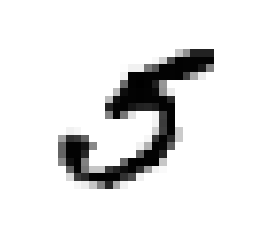

In [6]:
plt.imshow(digit, cmap="Greys")
plt.axis("off")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
X_train.shape

(60000, 784)

In [9]:
y_train.shape

(60000,)

In [10]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
y_train_5.shape

(60000,)

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

## Implementing Cross-Validation

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_folds = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.93285
0.9355
0.95785


make a classifier that only says "its a 5!"

In [19]:
from sklearn.base import BaseEstimator

In [20]:
class Never5Classifier(BaseEstimator):
    def fit(slef, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.90865,  0.91325,  0.90705])

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_train_5, y_train_pred)

In [25]:
norm_cfm = (cfm - np.min(cfm)) / (np.max(cfm)-np.min(cfm))

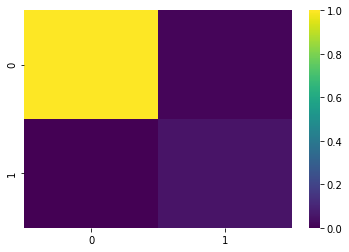

In [26]:
sns.heatmap(norm_cfm, cmap='viridis')

In [27]:
cfm

array([[52512,  2067],
       [ 1409,  4012]])

### Precision

Is the accuracy of the **positive prediction**:

$$ precision = \frac{TP}{TP+FP}$$



Precision is always used along another metric called **recall**, also called **sensitivity** or **true positive rate** (TPR). It is the ratio of positive instances that are correctly detected by the classifier.

$$ 
recall = \frac{TP}{TP+FN}
$$

In [28]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

In [29]:
precision_score(y_train_5, y_train_pred)

0.65997696989636456

In [30]:
recall_score(y_train_5, y_train_pred)

0.7400848551927689

### $F_1$ score

harmonic mean of precision and recall. Harmonic mean gives much more weight to low values. As result classifier only gets high $F_1$  score if both recall and precision are high.

$$
F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP+\frac{FN+FP}{2}}
$$

In [31]:
f1_score(y_train_5, y_train_pred)

0.69773913043478264